In [8]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
df = pd.read_csv('data/processed_data.csv')
df.head()

/var/folders/3v/mt54lbq96cn_vs_7nx_n24yc0000gn/T/ipykernel_43255/4014681682.py:1: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('processed_data.csv')


,match_id,season,start_date,venue,innings,ball,batting_team,bowling_team,striker,non_striker,...,extras_total,run_total,wickets,overs_left,run_rate,striker_score,non_striker_score,striker_rate,non_striker_rate,final_score
0,1310981.0,2022,5/24/2022,"Southend Club Cricket Stadium, Karachi",1.0,0.1,Sri Lanka,Pakistan,GWHM Perera,AC Jayangani,...,0.0,0.0,0,19.5,0.0,0.0,0.0,0.000000,0.0,106.0
1,1310981.0,2022,5/24/2022,"Southend Club Cricket Stadium, Karachi",1.0,0.2,Sri Lanka,Pakistan,GWHM Perera,AC Jayangani,...,0.0,4.0,0,19.4,12.0,4.0,0.0,200.000000,0.0,106.0
2,1310981.0,2022,5/24/2022,"Southend Club Cricket Stadium, Karachi",1.0,0.3,Sri Lanka,Pakistan,GWHM Perera,AC Jayangani,...,0.0,4.0,0,19.3,8.0,4.0,0.0,133.333333,0.0,106.0
3,1310981.0,2022,5/24/2022,"Southend Club Cricket Stadium, Karachi",1.0,0.4,Sri Lanka,Pakistan,GWHM Perera,AC Jayangani,...,0.0,4.0,1,19.2,6.0,0.0,0.0,0.000000,0.0,106.0
4,1310981.0,2022,5/24/2022,"Southend Club Cricket Stadium, Karachi",1.0,0.5,Sri Lanka,Pakistan,H Madavi,AC Jayangani,...,0.0,4.0,1,19.1,4.8,0.0,0.0,0.000000,0.0,106.0


In [10]:
X_data = df[['ball', 'run_total', 'wickets', 'striker_score', 'non_striker_score', 'overs_left', 'run_rate', 'striker_rate', 'non_striker_rate']]
Y_data = df[['final_score']]

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size = 0.2, random_state = 42)

In [12]:
# Fix data leakage - only fit scaler on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Only transform test data

In [ ]:
def create_model(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),

        # First hidden layer
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),

        # Second hidden layer
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),

        # Third hidden layer
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.1),

        # Output layer
        tf.keras.layers.Dense(1)
    ])

    # Compile with learning rate scheduling
    initial_learning_rate = 0.001
    optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model

model = create_model(X_train.shape[1])

In [ ]:
print("Model architecture:")
model.summary()

Model architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,417 (48.50 KB)

 Trainable params: 12,033 (47.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [15]:
# Enhanced callbacks with learning rate scheduling and longer patience
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    verbose=1
)

callbacks = [early_stop, lr_scheduler]

# K-Fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
fold_scores = []
fold_histories = []

print("Starting 5-Fold Cross Validation...")

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_scaled, Y_train)):
    print(f"\n=== Fold {fold + 1}/5 ===")

    # Split data for this fold
    X_train_fold = X_train_scaled[train_idx]
    X_val_fold = X_train_scaled[val_idx]
    y_train_fold = Y_train.iloc[train_idx]
    y_val_fold = Y_train.iloc[val_idx]

    # Create and train model for this fold
    fold_model = create_model(X_train.shape[1])

    fold_history = fold_model.fit(
        X_train_fold,
        y_train_fold,
        epochs=150,
        batch_size=64,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=callbacks,
        verbose=1
    )

    # Evaluate fold
    val_loss, val_mae = fold_model.evaluate(X_val_fold, y_val_fold, verbose=0)
    fold_scores.append(val_mae)
    fold_histories.append(fold_history)

    print(f"Fold {fold + 1} Validation MAE: {val_mae:.4f}")

print("\nCross-Validation Results:")
print(f"Mean MAE: {np.mean(fold_scores):.4f} (+/- {np.std(fold_scores) * 2:.4f})")
print(f"Individual fold scores: {[f'{score:.4f}' for score in fold_scores]}")

# Train final model on full training data
print("\nTraining final model on full training data...")
history = model.fit(
    X_train_scaled,
    Y_train,
    epochs=150,
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Starting 5-Fold Cross Validation...

=== Fold 1/5 ===
Epoch 1/150
7479/7479 ━━━━━━━━━━━━━━━━━━━━ 7s 803us/step - loss: 1403.4559 - mae: 26.7602 - val_loss: 769.0259 - val_mae: 19.9864 - learning_rate: 0.0010
Epoch 2/150
7479/7479 ━━━━━━━━━━━━━━━━━━━━ 6s 784us/step - loss: 916.6099 - mae: 22.7004 - val_loss: 889.5049 - val_mae: 20.1498 - learning_rate: 0.0010
Epoch 3/150
7479/7479 ━━━━━━━━━━━━━━━━━━━━ 6s 738us/step - loss: 894.3179 - mae: 22.3559 - val_loss: 1055.0970 - val_mae: 20.2044 - learning_rate: 0.0010
Epoch 4/150
7479/7479 ━━━━━━━━━━━━━━━━━━━━ 5s 732us/step - loss: 882.6758 - mae: 22.1621 - val_loss: 867.3041 - val_mae: 20.2318 - learning_rate: 0.0010
Epoch 5/150
7479/7479 ━━━━━━━━━━━━━━━━━━━━ 6s 748us/step - loss: 875.7339 - mae: 22.0630 - val_loss: 786.0499 - val_mae: 20.0729 - learning_rate: 0.0010
Epoch 6/150
7479/7479 ━━━━━━━━━━━━━━━━━━━━ 5s 731us/step - loss: 871.7593 - mae: 22.0073 - val_loss: 763.8632 - val_mae: 20.0042 - learning_rate: 0.0010
Epoch 7/150
7479/7479 ━━━━

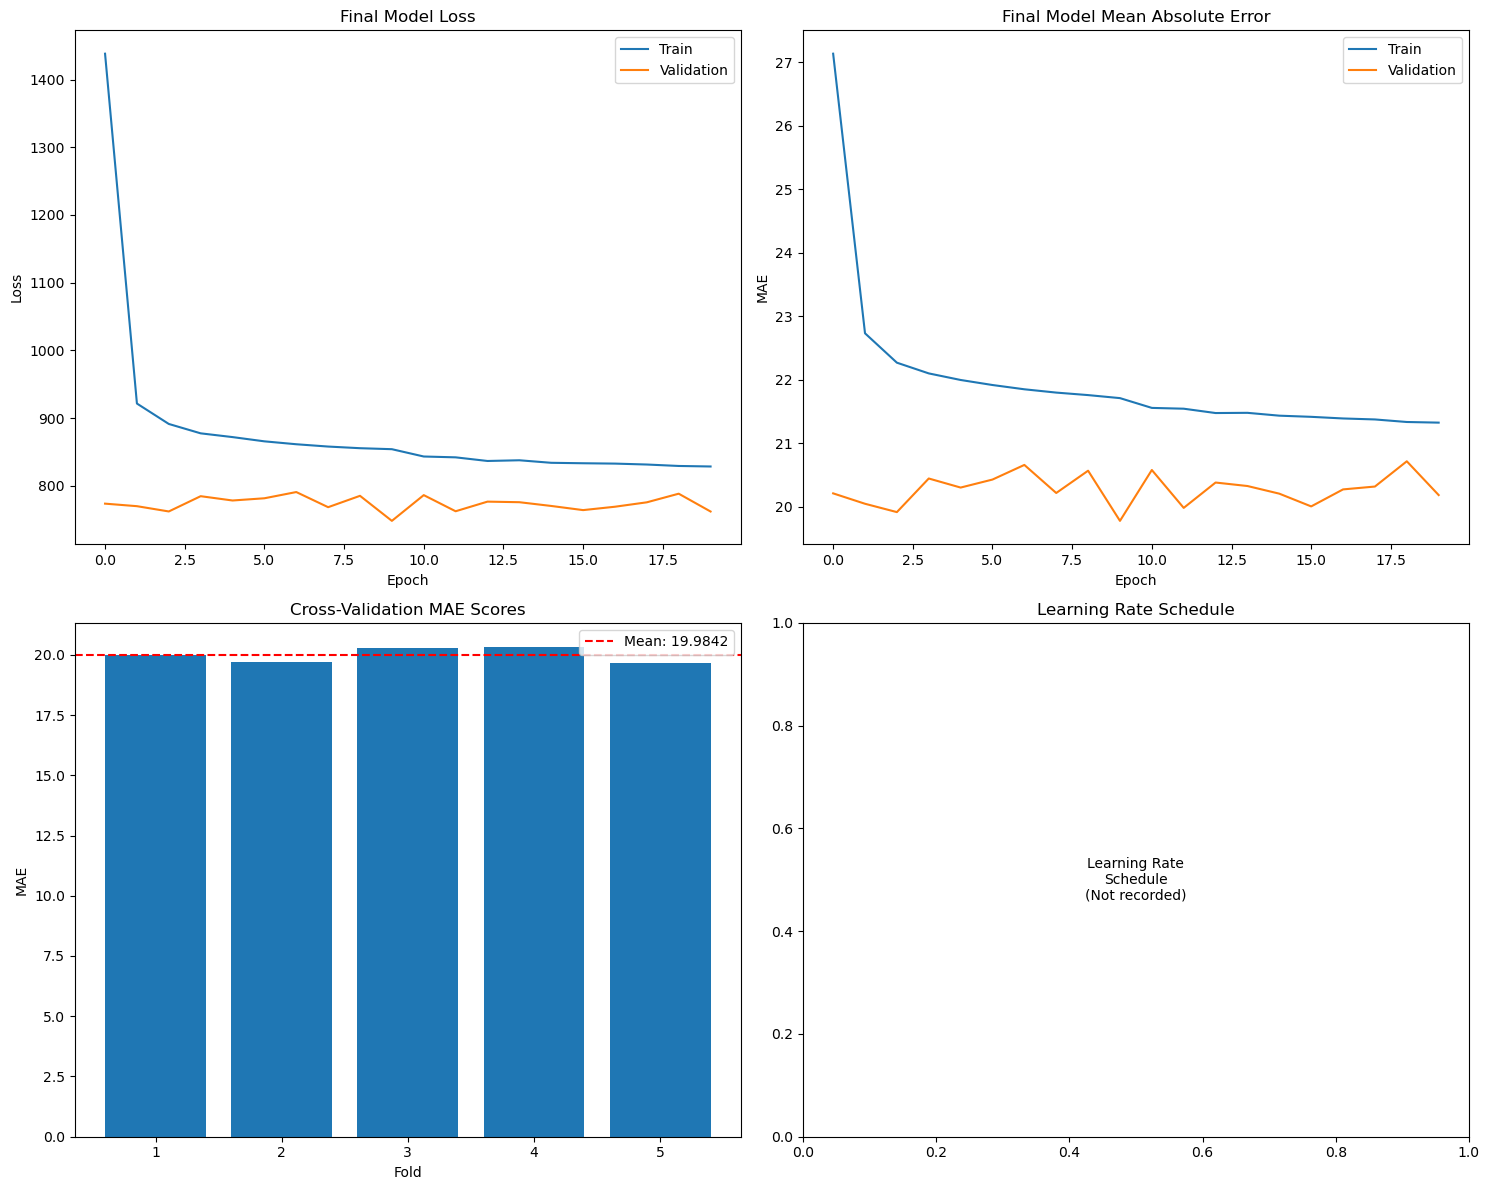


Training completed!
Cross-validation Mean MAE: 19.9842 (+/- 0.5560)
Final model training MAE: 19.7775
Training stopped at epoch: 20


In [16]:
# Enhanced plotting with cross-validation results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot final model training history
axes[0,0].plot(history.history['loss'])
axes[0,0].plot(history.history['val_loss'])
axes[0,0].set_title('Final Model Loss')
axes[0,0].set_ylabel('Loss')
axes[0,0].set_xlabel('Epoch')
axes[0,0].legend(['Train', 'Validation'], loc='upper right')

axes[0,1].plot(history.history['mae'])
axes[0,1].plot(history.history['val_mae'])
axes[0,1].set_title('Final Model Mean Absolute Error')
axes[0,1].set_ylabel('MAE')
axes[0,1].set_xlabel('Epoch')
axes[0,1].legend(['Train', 'Validation'], loc='upper right')

# Plot cross-validation scores
axes[1,0].bar(range(1, len(fold_scores) + 1), fold_scores)
axes[1,0].axhline(y=np.mean(fold_scores), color='r', linestyle='--', label=f'Mean: {np.mean(fold_scores):.4f}')
axes[1,0].set_title('Cross-Validation MAE Scores')
axes[1,0].set_xlabel('Fold')
axes[1,0].set_ylabel('MAE')
axes[1,0].legend()

# Plot learning rate schedule (if available)
if 'lr' in history.history:
    axes[1,1].plot(history.history['lr'])
    axes[1,1].set_title('Learning Rate Schedule')
    axes[1,1].set_ylabel('Learning Rate')
    axes[1,1].set_xlabel('Epoch')
    axes[1,1].set_yscale('log')
else:
    axes[1,1].text(0.5, 0.5, 'Learning Rate\nSchedule\n(Not recorded)',
                   ha='center', va='center', transform=axes[1,1].transAxes)
    axes[1,1].set_title('Learning Rate Schedule')

plt.tight_layout()
plt.show()

print("\nTraining completed!")
print(f"Cross-validation Mean MAE: {np.mean(fold_scores):.4f} (+/- {np.std(fold_scores) * 2:.4f})")
print(f"Final model training MAE: {min(history.history['val_mae']):.4f}")
print(f"Training stopped at epoch: {len(history.history['loss'])}")

In [17]:
#The mean error (in runs) of the model's predictions on the test data
test_loss, test_mae = model.evaluate(X_test_scaled, Y_test, verbose=0)
print(f"Test MAE: {test_mae}")

Test MAE: 20.134645462036133


In [18]:
#Some example predictions on the test data
predictions = model.predict(X_test_scaled)

df_predictions = pd.DataFrame({
    'Actual': Y_test.iloc[:, 0],
    'Predicted': predictions.flatten()
})
df_predictions.head(20)

4675/4675 ━━━━━━━━━━━━━━━━━━━━ 1s 235us/step


,Actual,Predicted
22512,72.0,79.841858
258251,194.0,160.665604
632983,98.0,122.452553
557115,177.0,182.079849
393814,126.0,125.481766
619622,108.0,138.349670
503333,119.0,119.948746
739885,167.0,125.060158
528007,116.0,125.911980
58610,99.0,133.609085


In [ ]:
# Save model architecture
model.save('model_files/cricket_score_predictor_v2.keras')

#Save scaler
joblib.dump(scaler, 'model_files/scaler_v2.pkl')

['scaler_v2.pkl']